In [34]:
# !wget https://www.dropbox.com/s/u83ae1efaah2w9o/UCMercedLanduse.zip
# !unzip UCMercedLanduse.zip

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights

from PIL import Image
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import os

### Import Dataset

In [2]:
df = pd.read_csv("UCMerced/multilabels.txt", sep="\t")
df.head()

IMAGE\LABEL  airplane  bare-soil  buildings  cars  chaparral  court  \
0  agricultural00         0          0          0     0          0      0   
1  agricultural01         0          0          0     0          0      0   
2  agricultural02         0          0          0     0          0      0   
3  agricultural03         0          0          0     0          0      0   
4  agricultural04         0          0          0     0          0      0   

   dock  field  grass  mobile-home  pavement  sand  sea  ship  tanks  trees  \
0     0      1      0            0         0     0    0     0      0      1   
1     0      1      0            0         0     0    0     0      0      0   
2     0      1      0            0         0     0    0     0      0      0   
3     0      1      0            0         0     0    0     0      0      0   
4     0      0      0            0         0     0    0     0      0      1   

   water  
0      0  
1      0  
2      0  
3      0  
4      0

In [3]:
classes = df.columns.to_list()[1:]
classes, len(classes)

(['airplane',
  'bare-soil',
  'buildings',
  'cars',
  'chaparral',
  'court',
  'dock',
  'field',
  'grass',
  'mobile-home',
  'pavement',
  'sand',
  'sea',
  'ship',
  'tanks',
  'trees',
  'water'],
 17)

In [4]:
class_count = pd.DataFrame(df.sum(axis=0)).reset_index()
class_count.columns = ["class", "Count"]
class_count.drop(class_count.index[0], inplace=True)
num_classes = len(classes)
print("Number of classes: ", num_classes)
print("Number of rows: ", len(df))
class_count

Number of classes:  17
Number of rows:  2100


class Count
1      airplane   100
2     bare-soil   718
3     buildings   691
4          cars   886
5     chaparral   115
6         court   105
7          dock   100
8         field   103
9         grass   975
10  mobile-home   102
11     pavement  1300
12         sand   294
13          sea   100
14         ship   102
15        tanks   100
16        trees  1009
17        water   203

In [5]:
df['all-labels'] = [ x.tolist() for x in  df.apply(lambda row: row[row == 1].index, axis=1)]
df['all-labels']= df['all-labels'].str.join(" ")
df.head()

IMAGE\LABEL  airplane  bare-soil  buildings  cars  chaparral  court  \
0  agricultural00         0          0          0     0          0      0   
1  agricultural01         0          0          0     0          0      0   
2  agricultural02         0          0          0     0          0      0   
3  agricultural03         0          0          0     0          0      0   
4  agricultural04         0          0          0     0          0      0   

   dock  field  grass  mobile-home  pavement  sand  sea  ship  tanks  trees  \
0     0      1      0            0         0     0    0     0      0      1   
1     0      1      0            0         0     0    0     0      0      0   
2     0      1      0            0         0     0    0     0      0      0   
3     0      1      0            0         0     0    0     0      0      0   
4     0      0      0            0         0     0    0     0      0      1   

   water   all-labels  
0      0  field trees  
1      0        field  
2      0        field  
3      0        field  
4      0        trees

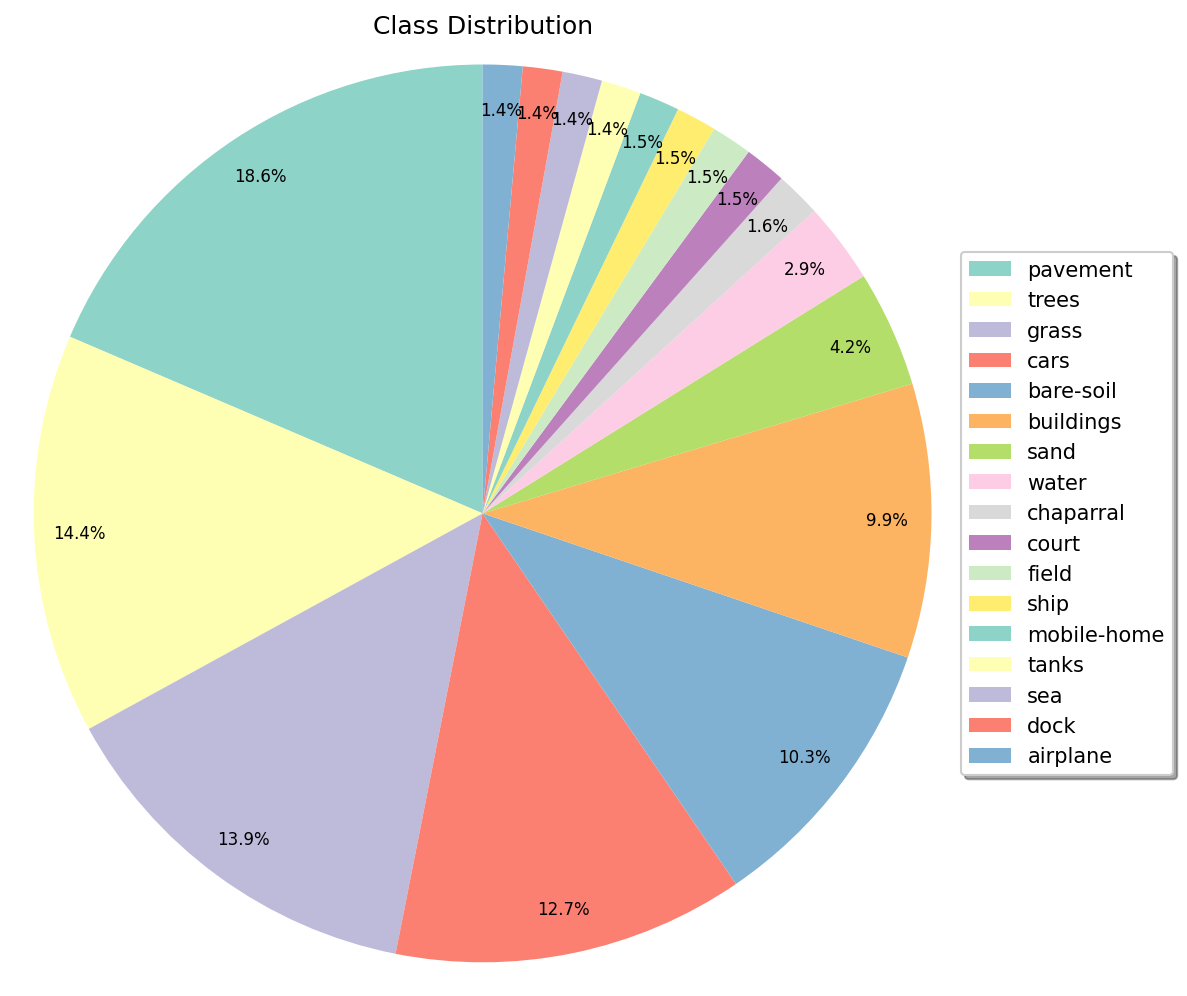

In [7]:
import seaborn as sns

# Calculate the number of images for each class
class_counts = df[classes].sum(axis=0).values

# Sort class_counts and classes based on class_counts
sorted_class_counts, sorted_classes = zip(*sorted(zip(class_counts, classes), reverse=True))

def format_percent(pct):
    if pct < 1:
        return ''
    return f'{pct:.1f}%'

# Plot a pie chart of class distribution
plt.figure(figsize=(8, 8), dpi=150)
plt.pie(
    sorted_class_counts, 
    autopct=format_percent, 
    startangle=90, 
    textprops={'fontsize': 8},
    colors=sns.color_palette('Set3'),
    pctdistance=0.9,
    radius=1.2
)
plt.title('Class Distribution')
plt.legend(sorted_classes, loc='center left', ncol=1, fancybox=True, shadow=True, bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.savefig(f'ucsmerced_dataset_classes.png', bbox_inches='tight')

plt.show()

In [6]:
# Define the getter for independent variable
def get_x(row): return '/Users/hotal/Desktop/MapHarvester/classification/UCMerced/images/'+row['IMAGE\LABEL']+'.tif'

# Define the getter for dependent variable
def get_y(row): row_df = pd.DataFrame(row).transpose(); return row_df.apply(lambda r: r[r == 1].index, axis=1)
# Define the getter for dependent variable
def get_y_v2(row): return row['all-labels'].split(" ")

# Define how to split the data into train and validation
def splitter(df):
    train, test = train_test_split(df, test_size=0.2)

    valid_idxs = test.index.tolist()
    train_idxs = train.index.tolist()

    return (train_idxs, valid_idxs)

In [7]:
device = torch.device("mps:0" if torch.backends.mps.is_available() else "cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='mps', index=0)

In [8]:
# Data augmentation and transformation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # !!!
])

In [9]:
# Define dataset class
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = get_x(self.dataframe.iloc[idx])
        image = Image.open(image_path)
        labels = get_y_v2(self.dataframe.iloc[idx])

        if self.transform:
            image = self.transform(image)

        # Convert labels to one-hot encoding
        label_vector = [1 if classes[i] in labels else 0 for i in range(num_classes)]

        return image, torch.tensor(label_vector, dtype=torch.float32)

# Define neural network architecture
class MultiClassifierModel(nn.Module):
    def __init__(self, num_classes):
        super(MultiClassifierModel, self).__init__()
        self.resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.fc = nn.Linear(1000, num_classes)  # !!!

    def forward(self, x):
        x = self.resnet(x)
        x = self.fc(x)
        return x

batch_size = 16

# Create the dataset and data loader
dataset = ImageDataset(df, transform=transform)
train_indices, val_indices = splitter(df)
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_indices)
val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_indices)

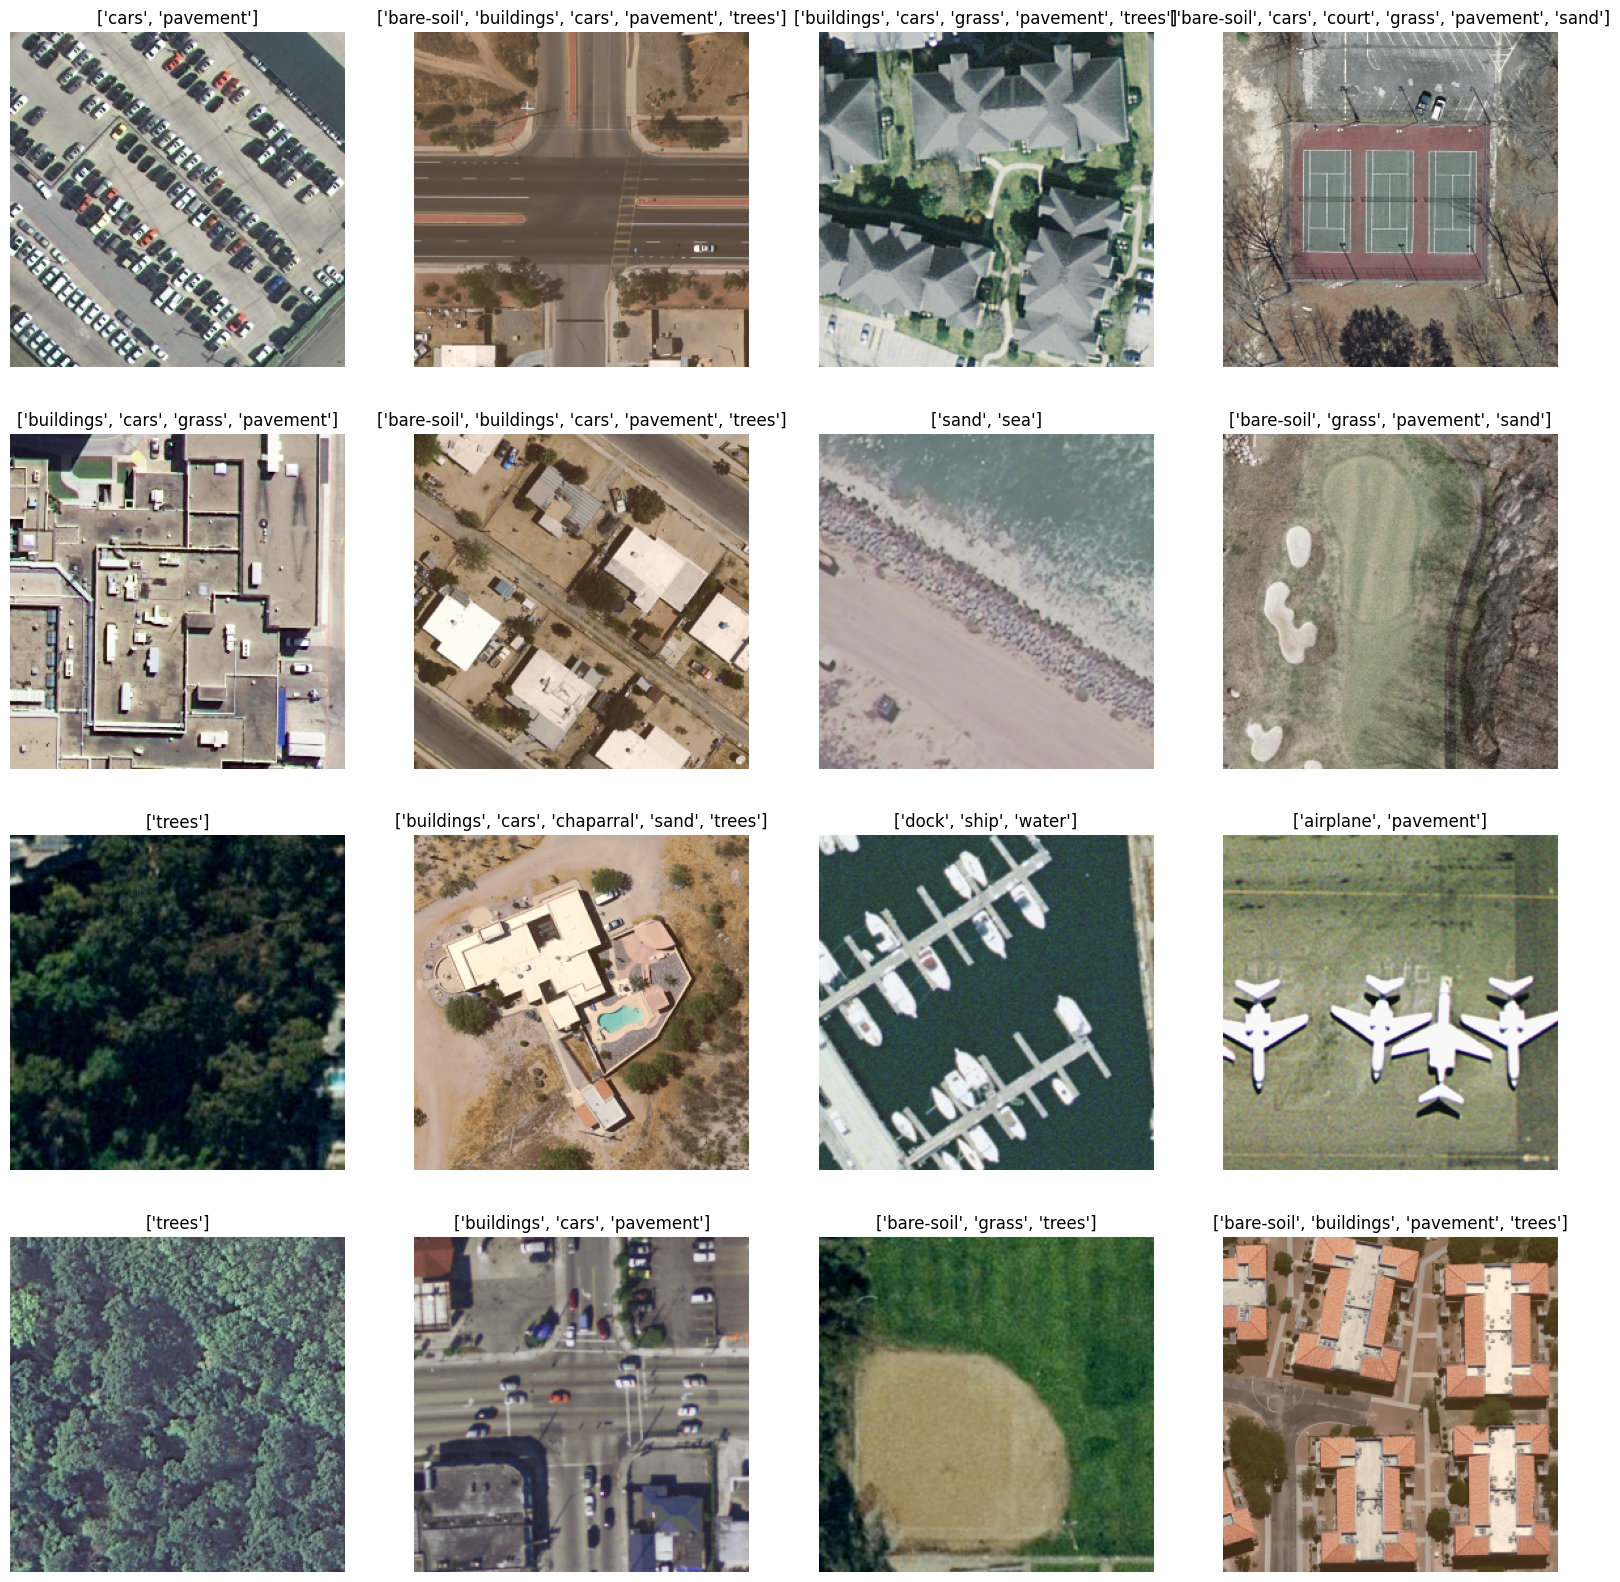

In [12]:
first_batch = next(iter(train_loader))

row = 4
col = 4
fig, ax = plt.subplots(row, col, figsize=(20, 20))

for i in range(row*col):
    matrix = first_batch[0][i].permute(1, 2, 0).numpy()
    scaled_matrix = (((matrix+1) * 255)/2).astype(np.uint8)
    ax[i//col][i%col].imshow(scaled_matrix)
    ax[i//col][i%col].axis('off')
    ax[i//col][i%col].set_title(str([classes[j] for j in range(num_classes) if first_batch[1][i][j] == 1]))

plt.show()

### Hyperparameter Optimization

In [ ]:
from skorch import NeuralNetClassifier
from skorch.dataset import ValidSplit

net = NeuralNetClassifier(
    module=MultiClassifierModel,
    optimizer=optim.Adam,
    criterion=nn.BCEWithLogitsLoss(),
    max_epochs=10,
    batch_size=8,
    lr=0.01, 
    verbose=1,
    train_split=ValidSplit(5, stratified=False),
)

param_grid = {
    'max_epochs': [10, 20, 30],
    'batch_size': [8, 16, 32],
    'lr': [0.001, 0.0005, 0.0001],
    'module__num_classes': [num_classes]
}

gs = GridSearchCV(net, param_grid, refit=False, scoring='f1_micro', verbose=1, cv=2)

counter = 0
search_batches = 2

for i, data in enumerate(train_loader):
    print("Batch: {}".format(i+1))
    counter += 1
    image, labels = data
    labels = labels.numpy() if isinstance(labels, torch.Tensor) else labels

    outputs = gs.fit(image, labels)


print('SEARCH COMPLETE')
print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))
# best score: 0.676, best params: {'batch_size': 16, 'lr': 0.0001, 'max_epochs': 30, 'module__num_classes': 17}

In [ ]:
import ray
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from filelock import FileLock

def load_data(df, transform, batch_size):
    # We add FileLock here because multiple workers will want to
    # download data, and this may cause overwrites since
    # DataLoader is not threadsafe.
    with FileLock(os.path.expanduser("~/.data.lock")):
        dataset = ImageDataset(df, transform=transform)
        train_indices, val_indices = splitter(df)
        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_indices)
        val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_indices)

    return train_loader, val_loader


# Define a function to train your model with hyperparameters as arguments
def train_model(config):
    num_epochs = config['num_epochs']
    batch_size = config['batch_size']
    learning_rate = config['learning_rate']

    # Initialize the model and optimizer
    model = MultiClassifierModel(num_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Adam optimizer
    criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss for multi-label classification

    # Create the dataset and data loader
    train_loader, val_loader = load_data(df, transform, batch_size)

    # Training loop
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0  # Initialize the loss for this epoch
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()  # Accumulate the loss for this batch
        
        # Calculate the average training loss for this epoch
        train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(train_loss)  # Store the training loss for plotting
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        # Calculate the average validation loss for this epoch
        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)  # Store the validation loss for plotting
        
        print(f'Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')


    # Return the final validation loss for Ray Tune to optimize
    return val_loss

# Define the search space for hyperparameters
search_space = {
    'num_epochs': tune.choice([10, 20, 30]),  # You can specify different values
    'batch_size': tune.choice([8, 16, 32, 64]),  # You can specify different values
    'learning_rate': tune.choice([0.001, 0.0005, 0.0001]),  # You can adjust the range
}

# Initialize Ray Tune
ray.shutdown()
ray.init()

# Create a reporter for reporting results
reporter = CLIReporter(
    parameter_columns=["num_epochs", "batch_size", "learning_rate"],
    metric_columns=["val_loss"],
)

# Use the ASHA scheduler for early stopping
scheduler = ASHAScheduler(
    max_t=30,
    grace_period=5,  # Number of epochs to wait before stopping low-performing trials
)

# Perform hyperparameter search using Ray Tune
analysis = tune.run(
    train_model,
    config=search_space,
    num_samples=8,
    scheduler=scheduler,
    progress_reporter=reporter,
    metric="val_loss",
    mode="min",
    log_to_file=False
)

# Get the best hyperparameters and corresponding result
best_trial = analysis.get_best_trial(metric="val_loss", mode="min")
best_hyperparameters = best_trial.config
best_val_loss = best_trial.last_result["val_loss"]

# Print the best hyperparameters and validation loss
print("Best Hyperparameters:", best_hyperparameters)
print("Best Validation Loss:", best_val_loss)

# Close Ray when finished
ray.shutdown()

### Training

In [27]:
# Training parameters
batch_size = gs.best_params_['batch_size']
learning_rate = gs.best_params_['lr']
num_epochs = 5 # gs.best_params_['max_epochs']
print("batch_size: {}, learning_rate: {}, num_epochs: {}".format(batch_size, learning_rate, num_epochs))

# Initialize the model and optimizer
model = MultiClassifierModel(num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Adam optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss for multi-label classification

# Create the dataset and data loader
dataset = ImageDataset(df, transform=transform)
train_indices, val_indices = splitter(df)
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_indices)
val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_indices)

batch_size: 16, learning_rate: 0.0001, num_epochs: 5


In [21]:
# Training loop
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0  # Initialize the loss for this epoch
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()  # Accumulate the loss for this batch
    
    # Calculate the average training loss for this epoch
    train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(train_loss)  # Store the training loss for plotting
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    # Calculate the average validation loss for this epoch
    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)  # Store the validation loss for plotting
    
    print(f'Epoch [{epoch+1}/{num_epochs}] | Val. Loss: {val_loss/len(val_loader):.4f}')


Epoch [1/5] | Val. Loss: 0.0044
Epoch [2/5] | Val. Loss: 0.0047
Epoch [3/5] | Val. Loss: 0.0043
Epoch [4/5] | Val. Loss: 0.0048
Epoch [5/5] | Val. Loss: 0.0044


### Evaluation

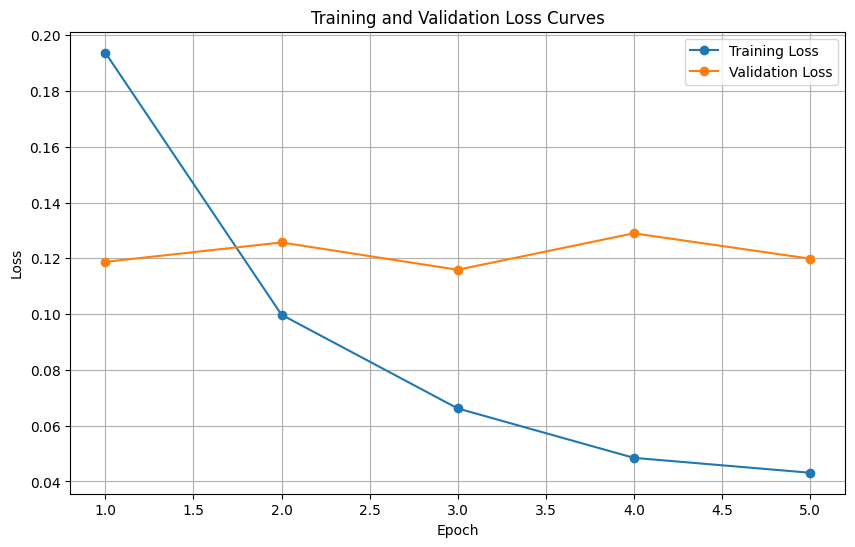

In [22]:
# Plot the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

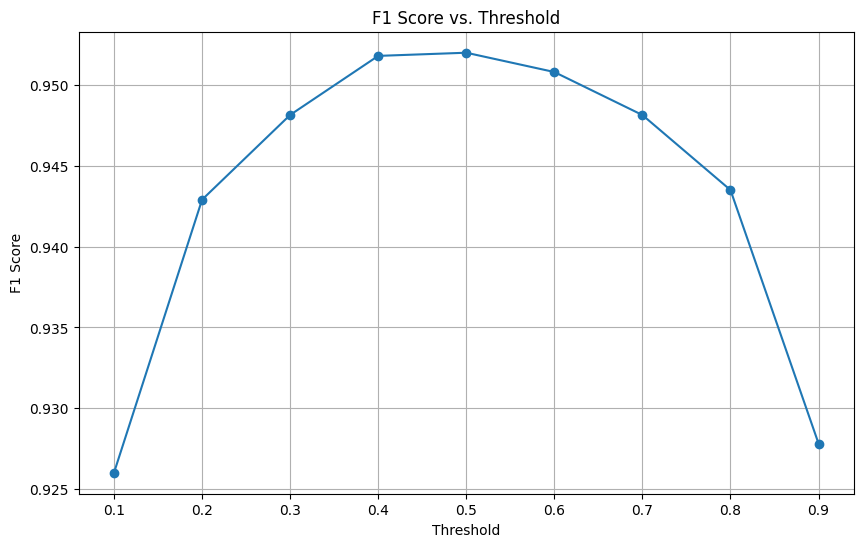

Best Threshold: 0.5
Accuracy: 0.7524
Precision: 0.9581
Recall: 0.9460
F1 Score: 0.9520
ROC AUC Score: 0.9973


In [14]:
# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Evaluate the model on the validation dataset
model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        # Apply sigmoid to the model outputs to get probability scores
        sigmoid = torch.nn.Sigmoid()
        predicted_probs = sigmoid(outputs).cpu().numpy()
        true_labels_batch = labels.cpu().numpy()
        
        true_labels.extend(true_labels_batch)
        predicted_labels.extend(predicted_probs)

# Convert the true_labels and predicted_labels lists to NumPy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# make a grid search for threshold
thresholds = np.arange(0.1, 1.0, 0.1)
f1_scores = []
for threshold in thresholds:
    predicted_class_labels = (predicted_labels > threshold).astype(int)
    f1 = f1_score(true_labels, predicted_class_labels, average='micro')
    f1_scores.append(f1)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, marker='o')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.grid(True)
plt.show()

# Define a threshold (e.g., 0.5) for class predictions
threshold = thresholds[np.argmax(f1_scores)]
predicted_class_labels = (predicted_labels > threshold).astype(int)

# Compute metrics
accuracy = accuracy_score(true_labels, predicted_class_labels)
precision = precision_score(true_labels, predicted_class_labels, average='micro')
recall = recall_score(true_labels, predicted_class_labels, average='micro')
f1 = f1_score(true_labels, predicted_class_labels, average='micro')
roc_auc = roc_auc_score(true_labels, predicted_labels, average='micro')

print(f'Best Threshold: {threshold:.1f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC Score: {roc_auc:.4f}')


In [26]:
# Save the model
# torch.save(model.state_dict(), f'MLC_{str(batch_size)}_{str(learning_rate)}_{str(num_epochs)}.pth')

### Test Images

In [13]:
# Load the model
model = MultiClassifierModel(num_classes).to(device)
model.load_state_dict(torch.load('./models/MLC_16_0.0001_5.pth', map_location=device))

<All keys matched successfully>

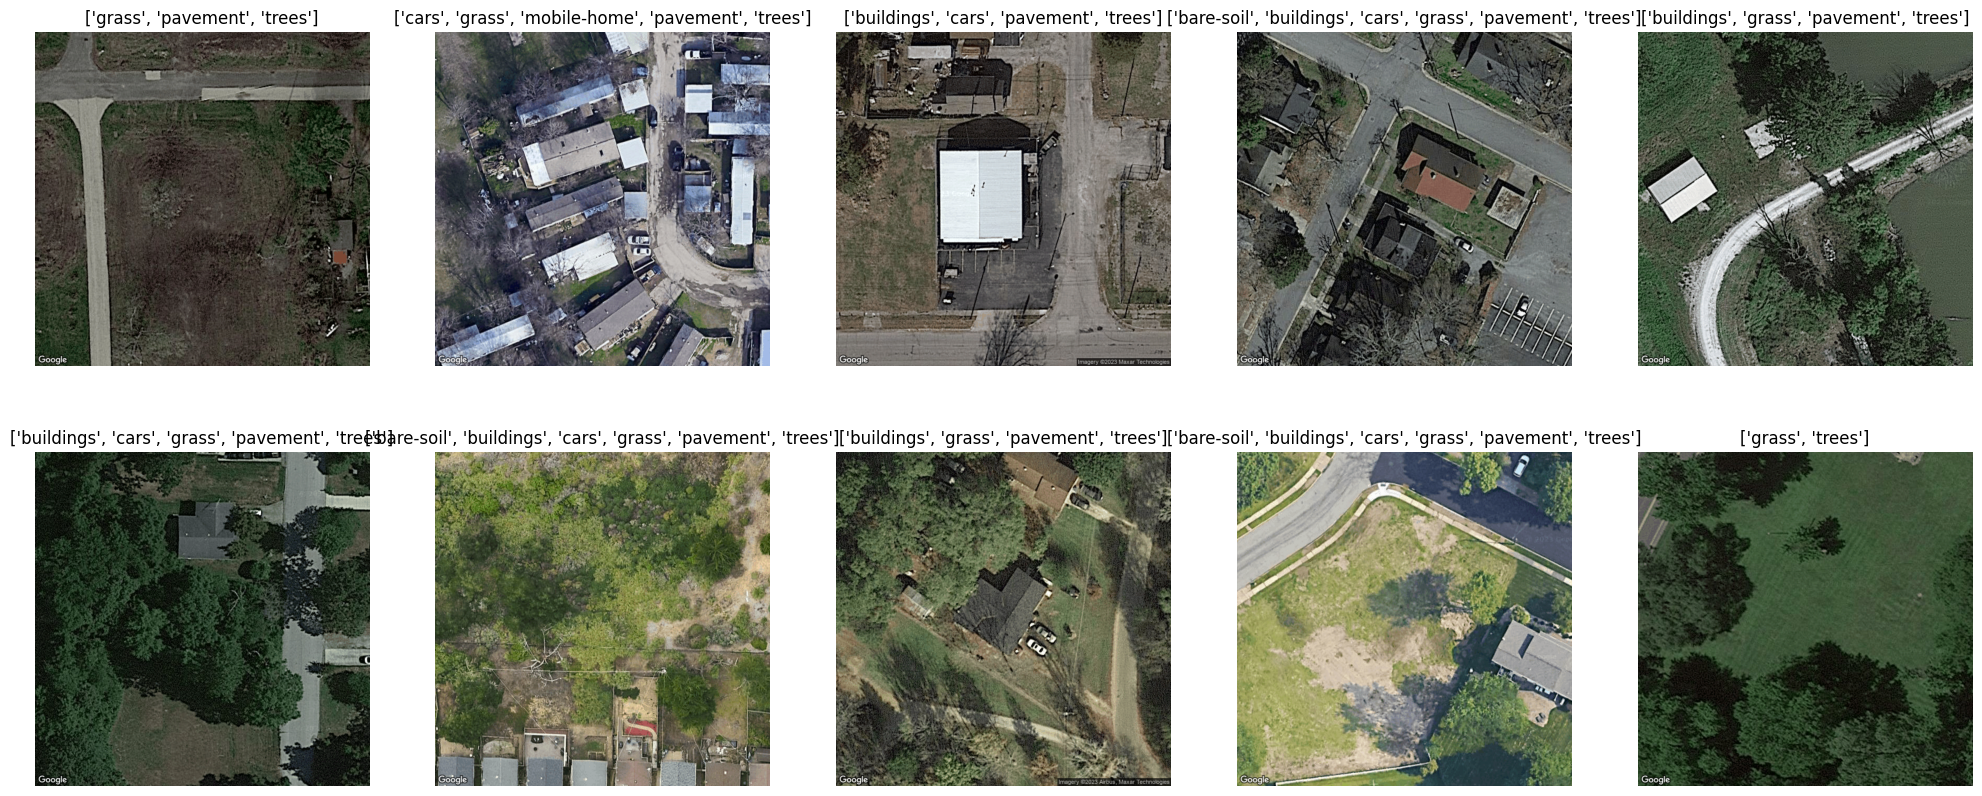

In [14]:
model.eval()  # Set the model to evaluation mode

# Define a function to preprocess the test image
def preprocess_test_image(image):
    image = transform(image)
    image = image.unsqueeze(0)  # Add a batch dimension
    return image

# Define a function to get predictions from the model
def get_predictions(model, image):
    with torch.no_grad():
        outputs = model(image)
        sigmoid = torch.nn.Sigmoid()
        predictions = sigmoid(outputs)  # Apply sigmoid to get probability scores
    return predictions


threshold = 0.5

row = 2
col = 5
fig, ax = plt.subplots(row, col, figsize=(25, 10))

for i in range(row*col):
    test_image = Image.open(f'../images_sat/{random.choice(os.listdir("../images_sat/"))}').convert('RGB')

    image = preprocess_test_image(test_image).to(device)
    predictions = get_predictions(model, image)
    pred_labels = [classes[i] for i in range(num_classes) if predictions[0][i] >= threshold]

    ax[i//col][i%col].imshow(test_image)
    ax[i//col][i%col].axis('off')
    ax[i//col][i%col].set_title(pred_labels)

plt.show()